<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Imports

In [30]:
import pandas as pd
import numpy as np
import operator
import sys
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [31]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [32]:
# Companies description
desc_df = pd.read_csv('../notebooks/content/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('../notebooks/content/stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [33]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This si something we will test out.

In [34]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'GE', 'F', 'NVDA', 'DLR', 'BRK.B', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

# Train Word Embeddings

In [67]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    fig, ax = pyplot.subplots(figsize=(20, 15)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(230, 30, n=9),
        ax=ax,
        annot_kws={"fontsize":20}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    pyplot.ylabel('Actual', fontsize = 20)
    pyplot.xlabel('Predicted', fontsize = 20)
    ax.set_title('Confusion Matrix', fontsize = 40, y = -.02)
    ax.set_xticklabels(class_names, fontsize=20, rotation=90)
    ax.set_yticklabels(class_names, rotation=0, fontsize = 20)
    b, t = pyplot.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    pyplot.ylim(b, t) # update the ylim(bottom, top) values
    pyplot.show() # ta-da! '''

Word2Vec(vocab=505, size=4, alpha=0.025)
('Accuracy is ', 0.5149700598802395)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


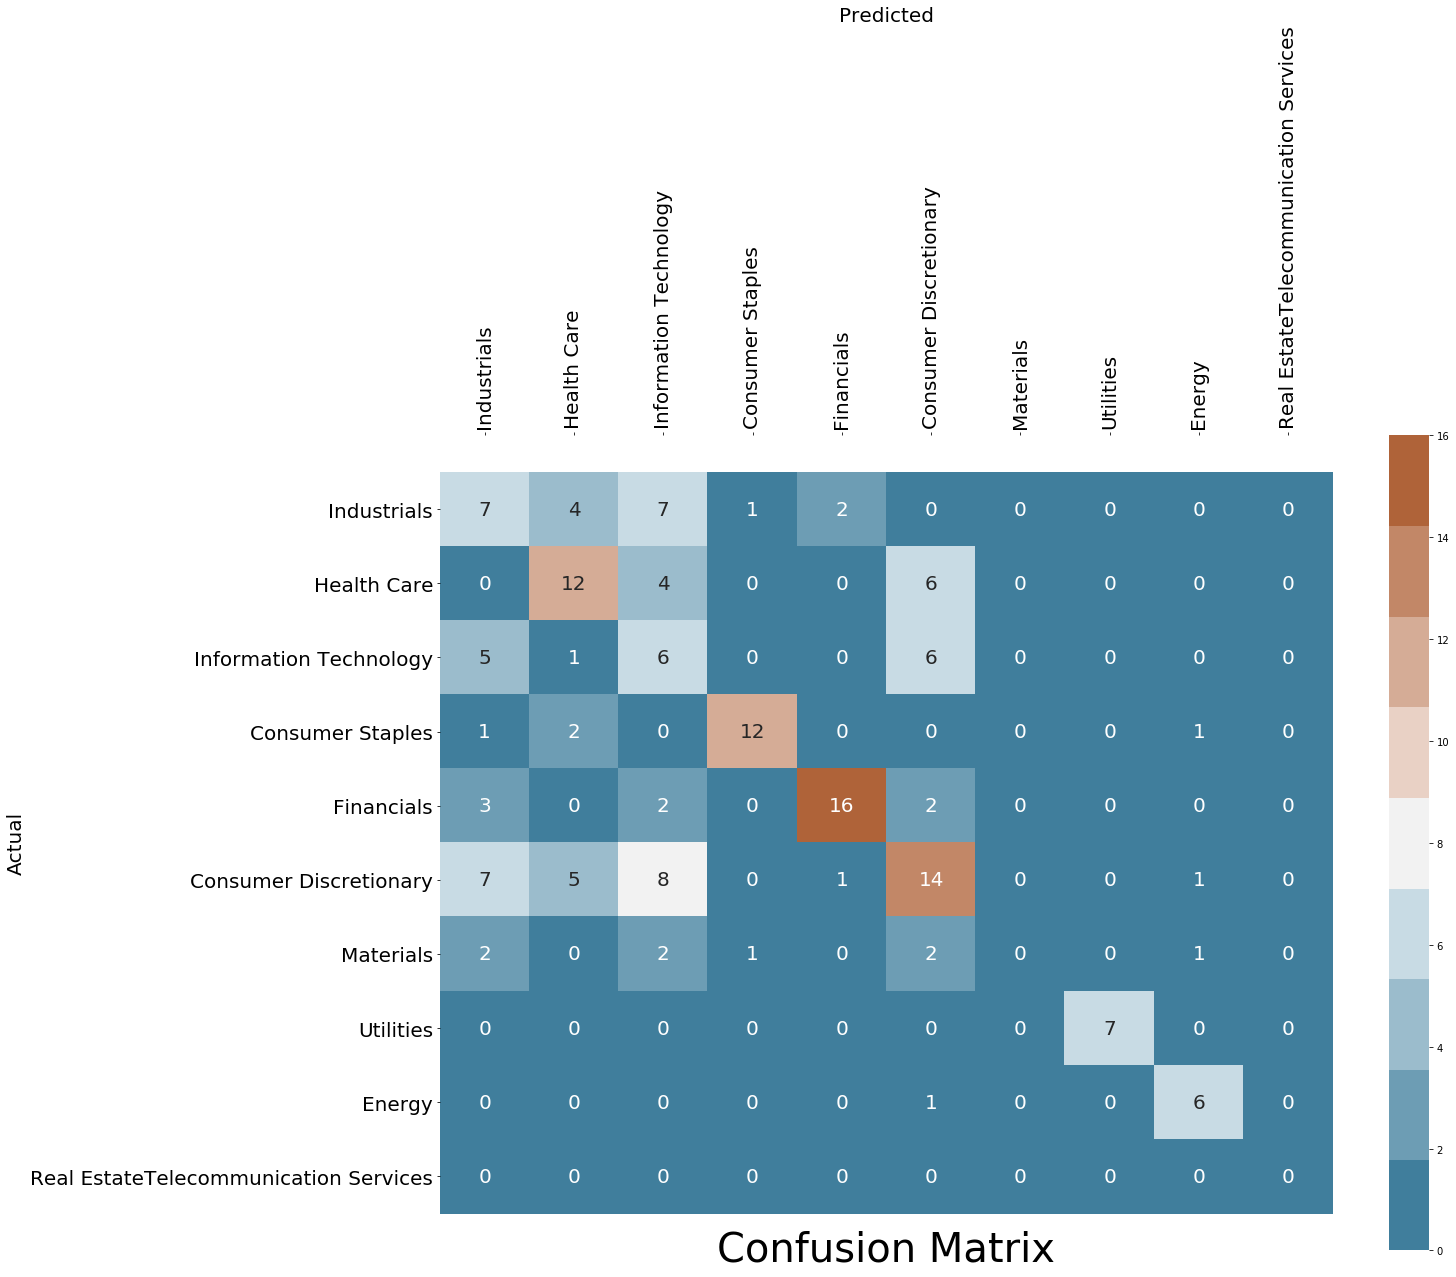

In [76]:
# train model
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Consumer Staples','Financials','Consumer Discretionary'
                      , 'Materials', 'Utilities','Energy', 'Real Estate'
                     'Telecommunication Services']
for j in range(4,5):
    model = Word2Vec(stocks_w2v_data, min_count=1, size=j)
    print(model)
    words = list(model.wv.vocab)
    X = model[model.wv.vocab]
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    train, test, train_labels, test_labels = train_test_split(X, Y, test_size=0.33, random_state=42)
    classifiers = []
    # Initialize our classifiers
    #model1 = GaussianNB()
    #classifiers.append(model1)
    model2 = svm.SVC(gamma = 1, C = 1)
    classifiers.append(model2)
    #model3 = tree.DecisionTreeClassifier()
    #classifiers.append(model3)
    #model4 = RandomForestClassifier()
    #classifiers.append(model4)
    # Train our classifier
    for clf in classifiers:
        clf.fit(train, train_labels)
        y_pred= clf.predict(test)
        acc = accuracy_score(test_labels, y_pred)
        print("Accuracy is ", acc)
        plot_cm(test_labels,y_pred,labels)
    #classifier = gnb.fit(train, train_labels)
    #preds = gnb.predict(test)
    #print(accuracy_score(test_labels, preds))

np.set_printoptions(threshold=sys.maxsize)


In [ ]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=2)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

In [ ]:
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

In [ ]:
# access vector for one word
print(model['AAL'])